Сейчас я хочу попробовать возможность Кераса делать собственные эмбеддинги. Я пользовалась вот этой статьёй:

https://realpython.com/python-keras-text-classification/

In [0]:
import numpy as np
import pandas as pd
from nltk.tokenize import wordpunct_tokenize
import emoji


In [0]:
!pip install emoji

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


In [6]:
import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.layers import Dense,Activation,Layer,Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


Using TensorFlow backend.


In [7]:
df_features = pd.read_csv('gk4z_features.csv')
df_features.head(2)

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
0,76000,#конкурс@the4gkz \r\r\r\nДля вашего удобства с...,17,post,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.0,23,0.045726,116,0.230616
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,34,post,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.0,0,0.000000,49,0.073244


In [0]:
def mapping(data,feature):
    featureMap=dict()
    count=0
    for i in sorted(data[feature].unique(),reverse=True):
        featureMap[i]=count
        count=count+1
    data[feature]=data[feature].map(featureMap)
    return data

In [0]:
df_features=mapping(df_features,feature="label")

Сначала нужно подготовить текст: отделить всю пунктуацию пробелами, иначе keras.tokenizer не сможет пунктуацию считать как отдельные токены.Я прочла об этом вот тут: https://stackoverflow.com/questions/49073673/include-punctuation-in-keras-tokenizer



In [0]:
# пишу функцию, которая добавляет пробелы с двух сторон к знакам препинания и смайликам.
my_punct = '«»...``\'\'•—!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def add_space(row):
  a = (''.join( (' '+i+' ') if i in my_punct else i for i in row['text']))
  text_with_spaces = (''.join( (' '+i+' ') if i in emoji.UNICODE_EMOJI else i for i in a))
  return text_with_spaces


In [0]:
#делаю отдельную колонку с подготовленным текстом
df_features['extra_space'] =df_features.apply(add_space, axis=1)



In [12]:
# смотрю,появилась ли новая колонка
df_features.head(2)

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%,extra_space
0,76000,#конкурс@the4gkz \r\r\r\nДля вашего удобства с...,17,0,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.0,23,0.045726,116,0.230616,# конкурс @ the4gkz \r\r\r\nДля вашего удобст...
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,34,0,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.0,0,0.000000,49,0.073244,Уже сегодня ночью ( по МСК ) начнётся один и...


In [0]:
# делю датасет на тест и трейн
X = df_features['extra_space'].values
y = df_features['label'].values

text_train, text_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [14]:
# ставлю в токенайзере пустой фильтр, чтобы он не отфильтровывал знаки препинания (по умолчанию он отфильтровывает)
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print(vocab_size)
# смотрю, как закодировались слова:
print(text_train[49])
print(X_train[49])
print(text_train[610])
print(X_train[610])




61614
а они не отстали
[13, 45, 6, 25224]
Служить ментом ,  чё
[25716, 25717, 1, 853]


The indexing is ordered after the most common words in the text. Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information.

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number.

In [15]:
 maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0])

[    6 25181  5262   305   337    15     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


Now you can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

input_dim: the size of the vocabulary

output_dim: the size of the dense vector

input_length: the length of the sequence

With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:

In [0]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
def classif_report(current_model):
    predY=current_model.predict(X_test) 
    new_ar = []
    for el in predY:
        new_ar.append(np.argmax(el))
    print(classification_report(y_test, new_ar))


## Model 1

In [24]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.Flatten())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(3, activation=tf.nn.softmax))
model1.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           3080700   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 33        
Total params: 3,130,853
Trainable params: 3,130,853
Non-trainable params: 0
_________________________________________________________________


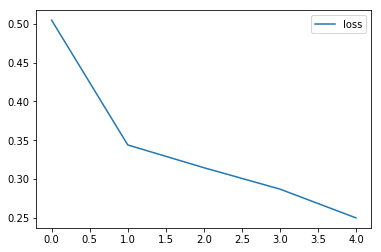

In [25]:
history = model1.fit(X_train, y_train, epochs=5, callbacks = [plot_losses])

In [26]:
classif_report(model1)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3443
           1       0.55      0.56      0.56      1132
           2       0.89      0.89      0.89      8384

   micro avg       0.86      0.86      0.86     12959
   macro avg       0.77      0.77      0.77     12959
weighted avg       0.86      0.86      0.86     12959



Отличный результат для комментов второго уровня!

## Model 2

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size.

In [18]:
embedding_dim = 50

model2 = Sequential()
model2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2.add(layers.GlobalMaxPool1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(3, activation=tf.nn.softmax))
model2.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model2.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3080700   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 3,081,353
Trainable params: 3,081,353
Non-trainable params: 0
_________________________________________________________________


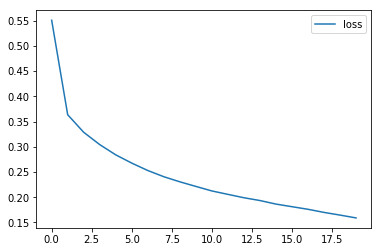

In [19]:
history = model2.fit(X_train, y_train, epochs=20, callbacks = [plot_losses])

In [20]:
classif_report(model2)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      3443
           1       0.57      0.44      0.50      1132
           2       0.86      0.91      0.88      8384

   micro avg       0.84      0.84      0.84     12959
   macro avg       0.76      0.72      0.74     12959
weighted avg       0.84      0.84      0.84     12959



Я попробовала с epochs=5, 10 и 20, и результат ни разу не был лучше.

## Model 2_w

попробую добавить веса

In [21]:
embedding_dim = 50

model2_w = Sequential()
model2_w.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2_w.add(layers.GlobalMaxPool1D())
model2_w.add(layers.Dense(10, activation='relu'))
model2_w.add(layers.Dense(10, activation='relu'))
model2_w.add(layers.Dense(3, activation=tf.nn.softmax))
model2_w.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model2_w.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           3080700   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 3,081,353
Trainable params: 3,081,353
Non-trainable params: 0
_________________________________________________________________


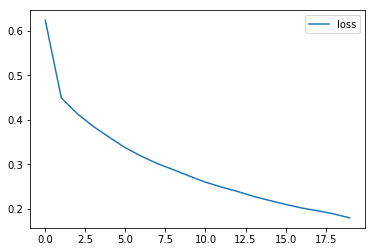

In [23]:
history = model2_w.fit(X_train, y_train, epochs=20, class_weight= {0:1, 1:4, 2:0.5}, callbacks = [plot_losses])

In [25]:
classif_report(model2_w)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      3443
           1       0.28      0.80      0.41      1132
           2       0.87      0.65      0.75      8384

   micro avg       0.70      0.70      0.70     12959
   macro avg       0.64      0.74      0.64     12959
weighted avg       0.79      0.70      0.73     12959



Веса явно сработали, но лучше не стало. 

## Model 2_w_b

Попробую поставить чуть более сбалансированные веса и меньшее количество эпох

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([1.27977484, 3.8534047 , 0.510438  ])

In [28]:
embedding_dim = 50

model2_w_b = Sequential()
model2_w_b.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2_w_b.add(layers.GlobalMaxPool1D())
model2_w_b.add(layers.Dense(10, activation='relu'))
model2_w_b.add(layers.Dense(10, activation='relu'))
model2_w_b.add(layers.Dense(3, activation=tf.nn.softmax))
model2_w_b.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model2_w_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           3080700   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 33        
Total params: 3,081,353
Trainable params: 3,081,353
Non-trainable params: 0
_________________________________________________________________


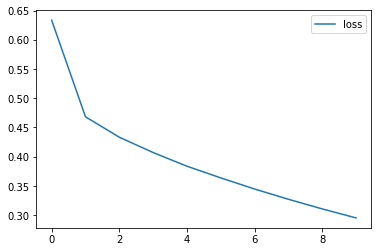

In [29]:
history = model2_w_b.fit(X_train, y_train, epochs=10, class_weight= {0:1.27977484, 1:3.8534047, 2:0.510438}, callbacks = [plot_losses])

In [30]:
classif_report(model2_w_b)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3443
           1       0.35      0.79      0.49      1132
           2       0.91      0.70      0.79      8384

   micro avg       0.76      0.76      0.76     12959
   macro avg       0.68      0.79      0.70     12959
weighted avg       0.83      0.76      0.78     12959



В общем, здесь с помощью весов мы добиваемся увеличения параметра recall комментов к комментам за счет обычных комментов. Я не думаю, что это есть хорошо.

## Model 3

In [27]:
embedding_dim = 50

model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model3.add(layers.GlobalAveragePooling1D())
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(3, activation=tf.nn.softmax))
model3.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           3080700   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
Total params: 3,081,353
Trainable params: 3,081,353
Non-trainable params: 0
_________________________________________________________________


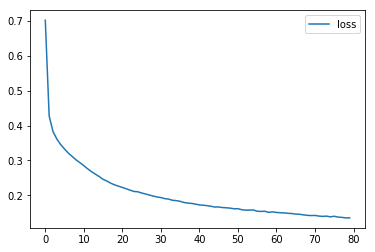

In [28]:
history = model3.fit(X_train, y_train, epochs=80, callbacks = [plot_losses]) #55 эпох - loss 0.17

In [29]:
classif_report(model3)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      3443
           1       0.51      0.59      0.55      1132
           2       0.86      0.90      0.88      8384

   micro avg       0.84      0.84      0.84     12959
   macro avg       0.76      0.76      0.76     12959
weighted avg       0.85      0.84      0.84     12959



## 4
буду настраивать модель со слоем Flatten. Попробую другое количество нейронов))

In [21]:
embedding_dim = 100

model4 = Sequential()
model4.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model4.add(layers.Flatten())
model4.add(layers.Dense(50, activation='relu'))
model4.add(layers.Dense(50, activation='relu'))
model4.add(layers.Dense(3, activation=tf.nn.softmax))
model4.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          6161400   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                500050    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 6,664,153
Trainable params: 6,664,153
Non-trainable params: 0
_________________________________________________________________


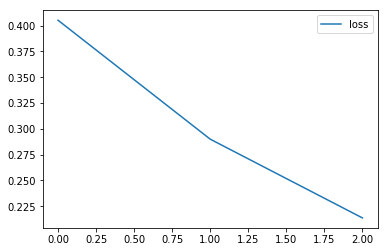

In [22]:
history = model4.fit(X_train, y_train, epochs=3, callbacks = [plot_losses]) 

In [23]:
classif_report(model4)

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3443
           1       0.62      0.51      0.56      1132
           2       0.88      0.92      0.90      8384

   micro avg       0.87      0.87      0.87     12959
   macro avg       0.80      0.76      0.78     12959
weighted avg       0.86      0.87      0.86     12959



10 эпох для этой модели - переобучение. Три эпохи - отличный результат. Но, в общем-то, такой же,  как у  модели 1 и у  модели 3, третья модель только долго обучается в сравнении с этими двумя.

